In [18]:
include("../code/plotting_utilities.jl")
include("../code/ode_helper.jl")
include("../code/learn_polynomial_with_side_info.jl")
include("../code/vectorfield_helper.jl")

using Dates
using SumOfSquares
using DynamicPolynomials
using MosekTools
using Plots
using Random
using PyPlot
using JSON
using ProgressBars
PyPlot.rc("font", family="sans-serif", size=20)
PyPlot.rc("figure", autolayout=true)

Loaded diff equations


In [19]:
m = 1.
g = 1.
ℓ = 1.
k = 1.
α = g / ℓ

function pendulum_true_vf(x, ẋ)
    return [ẋ, - g / ℓ * sin(x)]
end


function get_trajectory(vf, x0, noise_level, length, Tf; verbose=true)
    # special for pendulum because it's second order
    # the second component of x should match the first component of x_dot
    Random.seed!(0)
    training_x = hcat(solve_ode(vf, x0; verbose=verbose, length=length, tspan=(0, Tf))...)'
    training_xdot = vf.(training_x[1, :], training_x[2, :])
    training_xdot = hcat(training_xdot...)
    training_xdot = training_xdot + noise_level * randn(size(training_xdot))
    training_x = training_x + noise_level * randn(size(training_xdot))
    training_xdot[1, :] = training_x[2, :]
    training_x, training_xdot
end

get_trajectory (generic function with 1 method)

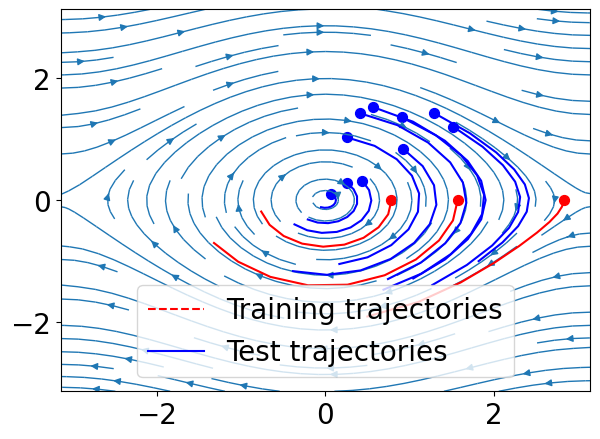

PyObject <matplotlib.legend.Legend object at 0x7f5db6365e20>

In [20]:
gr(size=(600,400))

ff = pendulum_true_vf
Tf = 3. # T final
box = ((-π, π, .1), (-π, π, .1))
plot_vectorfield(ff, (-π, π, 50), (-π, π, 50))

training_initial_conditions = [ [π/4, 0], [.9 * π, 0.], [.5 * π, 0.]]
Random.seed!(0)
test_initial_conditions = [rand(2) .* π/2 for _ in 1:10]
#initial_conditions = [rand(2) for _ in 1:10]
for x0 in training_initial_conditions[1:end]
    sol = solve_ode(ff, x0, tspan = (0., Tf), verbose=false)
    PyPlot.plot(sol..., color=:red)
    PyPlot.scatter(x0[1], x0[2], color=:red, s=50)
end

for x0 in test_initial_conditions[1:end]
    sol = solve_ode(ff, x0, tspan = (0., Tf), verbose=false)
    PyPlot.plot(sol..., color=:blue)
    PyPlot.scatter(x0[1], x0[2], color=:blue, s=50)
end


PyPlot.plot([], [], color=:red, ls="--", label="Training trajectories")
PyPlot.plot([], [], color=:blue, label="Test trajectories")
PyPlot.legend()


In [21]:
second_order_model(model, p, x) = begin
    x1, x2 = x
    p1, p2 = p
    @constraint(model, coefficients(p1 - x2) .== 0)
end

symmetry(model, p, x) = begin
    x1, x2 = x
    p1, p2 = p
   
   @constraint model coefficients(p2 + p2(x1 => -x1, x2 => -x2)) .== 0
end


sign_constraints(model, p, x) = begin
    x1, x2 = x
    p1, p2 = p
    Sp = @set x1 >= 0
    @constraint(model, p2 <= 0, domain = Sp)
    Sm = @set x1 <= 0
    @constraint(model, p2 >= 0, domain = Sm)
end

hamiltonian(model, p, x) = begin
    x1, x2 = x
    deg = maximum(MultivariatePolynomials.degree.(MultivariatePolynomials.terms(p[1]), x[1]))
    max_deg = deg + 1
    monomials = [x1^i * x2^j for i=0:max_deg for j=0:max_deg if i+j < max_deg && i + j > 0]
    @variable model c[1:size(monomials, 1)]
    H = monomials' * c
    Hx = differentiate(H, x1)
    Hy = differentiate(H, x2)
    coeffs = reduce(vcat, coefficients.(p .-  [Hy, -Hx]))
    @constraint(model,  coeffs .== 0)
    
end

hamiltonian (generic function with 1 method)

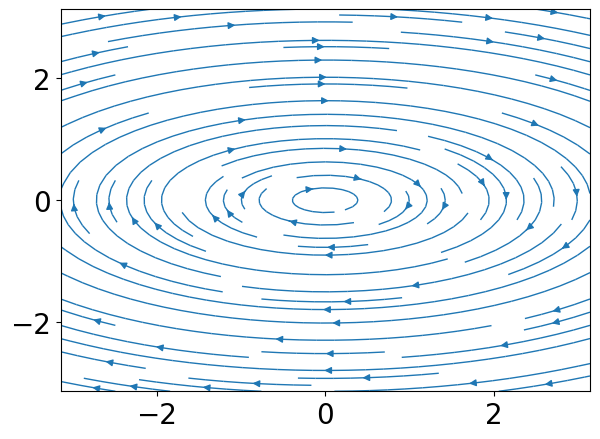

PyObject <matplotlib.streamplot.StreamplotSet object at 0x7f5d9e103610>

In [22]:
deg = 5
noise_level = .01
num_trajectories = 2
num_samples = 5
side_info = Dict(
    "second_order_model" => second_order_model,
    "symmetry" => symmetry,
    "sign_constraints" => sign_constraints,
    "hamiltonian" => hamiltonian,
)
r = train_and_test_model(deg, noise_level, num_trajectories, num_samples, side_info, 
    training_initial_conditions,
        test_initial_conditions, Tf, ((-1, 1, .1), (-1, 1, .1)); verbose=false)
plot_vectorfield(
    (a...) ->  map(pi -> pi(a), r["learned_p"]),
    (-π, π, 50), (-π, π, 50))


In [23]:
side_info = [
    Dict(),
    Dict(
    "second_order_model" => second_order_model),
    Dict(
    "second_order_model" => second_order_model,
    "symmetry" => symmetry),
    Dict(
    "second_order_model" => second_order_model,
    "symmetry" => symmetry,
    "sign_constraints" => sign_constraints),
    Dict(
    "second_order_model" => second_order_model,
    "symmetry" => symmetry,
    "sign_constraints" => sign_constraints,
    "hamiltonian" => hamiltonian),
]
    
deg = (2, 3, 4, 5, 6)
noise_level = (0, 1e-3, 1e-2, 1e-1, )
num_trajectories = (1, 2, 3)
num_samples = (5, 10, 20,)

results = [train_and_test_model(args...,
                                training_initial_conditions,
                                test_initial_conditions, Tf, box; verbose=false)
                for args in tqdm(Iterators.product(deg, noise_level, num_trajectories, num_samples, side_info))];

0.0%┣                                             ┫ 0/900 [00:00<00:-45, -0s/it]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

1.7%┣▊                                             ┫ 15/900 [00:05<04:55, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
3.8%┣█▊                                            ┫ 34/900 [00:10<04:33, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
3.9%┣█▉                                            ┫ 35/900 [00:11<04:36, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

5.9%┣██▊                                           ┫ 53/900 [00:17<04:38, 3it/s]
6.0%┣██▊                                           ┫ 54/900 [00:17<04:39, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
6.1%┣██▉                                           ┫ 55/900 [00:18<04:41, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
9.7%┣████▌                                         ┫ 87/900 [00:28<04:29, 3it/s]
9.8%┣████▌                                         ┫ 88/900 [00:29<04:28, 3it/s]
9.9%┣████▌                                         ┫ 89/900 [00:29<04:28, 3it/s]
10.0%┣████▌                                        ┫ 90/900 [00:30<04:30, 3it/s]
10.1%┣████▌                                        ┫ 91/900 [00:30<04:29, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.jul

12.2%┣█████▍                                      ┫ 110/900 [00:36<04:21, 3it/s]
12.3%┣█████▍                                      ┫ 111/900 [00:36<04:21, 3it/s]
12.4%┣█████▌                                      ┫ 112/900 [00:37<04:20, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src

14.1%┣██████▏                                     ┫ 127/900 [00:41<04:13, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
14

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
15.4%┣██████▉                                     ┫ 139/900 [00:44<04:03, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
15.6%┣██████▉                                     ┫ 140/900 [00:44<04:03, 3it/s]
15.7%┣███████                                     ┫ 141/900 [00:45<04:03, 3it/s]
15.8%┣███████                                     ┫ 142/900 [00:45<04:03, 3it/s]
15.9%┣███████                                     ┫ 143/900 [00:45<04:02, 3it/s]
16.0%┣███████                                     ┫ 144/900 [00:46<04:02, 3it/s]
16.1%┣███████                                     ┫ 145/900 [00:46<04:03, 3it/s]
16.2%┣███████▏                          

19.4%┣████████▋                                   ┫ 175/900 [00:57<03:56, 3it/s]
19.6%┣████████▋                                   ┫ 176/900 [00:57<03:56, 3it/s]
19.7%┣████████▋                                   ┫ 177/900 [00:57<03:55, 3it/s]
19.8%┣████████▊                                   ┫ 178/900 [00:58<03:55, 3it/s]
19.9%┣████████▊                                   ┫ 179/900 [00:58<03:55, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
20.0%┣████████▉                                   ┫ 180/900 [00:59<03:56, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interfa

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
22.1%┣█████████▊                                  ┫ 199/900 [01:04<03:48, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

24.1%┣██████████▋                                 ┫ 217/900 [01:10<03:40, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
24.2%┣██████████▋                                 ┫ 218/900 [01:10<03:40, 3it/s]
24.3%┣██████████▊                                 ┫ 219/900 [01:10<03:39, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src

26.9%┣███████████▉                                ┫ 242/900 [01:18<03:32, 3it/s]
27.0%┣███████████▉                                ┫ 243/900 [01:18<03:32, 3it/s]
27.1%┣████████████                                ┫ 244/900 [01:18<03:32, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
27.2%┣████████████                                ┫ 245/900 [01:19<03:31, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instabilit

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
30.8%┣█████████████▌                              ┫ 277/900 [01:28<03:19, 3it/s]
30.9%┣█████████████▋                              ┫ 278/900 [01:28<03:19, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

32.8%┣██████████████▍                             ┫ 295/900 [01:33<03:12, 3it/s]
32.9%┣██████████████▌                             ┫ 296/900 [01:34<03:12, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
33.0%┣██████████████▌                             ┫ 297/900 [01:34<03:12, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src

34.4%┣███████████████▏                            ┫ 310/900 [01:37<03:06, 3it/s]
34.6%┣███████████████▏                            ┫ 311/900 [01:38<03:06, 3it/s]
34.7%┣███████████████▎                            ┫ 312/900 [01:38<03:05, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src

37.2%┣████████████████▍                           ┫ 335/900 [01:44<02:57, 3it/s]
37.3%┣████████████████▍                           ┫ 336/900 [01:45<02:56, 3it/s]
37.4%┣████████████████▌                           ┫ 337/900 [01:45<02:56, 3it/s]
37.6%┣████████████████▌                           ┫ 338/900 [01:45<02:56, 3it/s]
37.7%┣████████████████▋                           ┫ 339/900 [01:46<02:55, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.jul

40.9%┣██████████████████                          ┫ 368/900 [01:55<02:46, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
41.0%┣██████████████████                          ┫ 369/900 [01:55<02:46, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLB

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
42.2%┣██████████████████▋                         ┫ 380/900 [01:57<02:41, 3it/s]
42.3%┣██████████████████▋                         ┫ 381/900 [01:58<02:41, 3it/s]
42.4%┣██████████████████▊                         ┫ 382/900 [01:58<02:40, 3it/s]
42.6%┣██████████████████▊                         ┫ 383/900 [01:58<02:40, 3it/s]
42.7%┣██████████████████▊                         ┫ 384/900 [01:59<02:40, 3it/s]
42.8%┣██████████████████▉                         ┫ 385/900 [01:59<02:39, 3it/s]
42.9%┣██████████████████▉                         ┫ 386/900 [01:59<02:39, 3it/s]
43.0%┣███████████████████                         ┫ 387/900 [01:59<02:39, 3it/s]
43.1%┣███████████████████                         ┫ 388/900 [02:00<02:38, 3it/s]
┌ Warning

46.7%┣████████████████████▌                       ┫ 420/900 [02:10<02:29, 3it/s]
46.8%┣████████████████████▋                       ┫ 421/900 [02:10<02:28, 3it/s]
46.9%┣████████████████████▋                       ┫ 422/900 [02:10<02:28, 3it/s]
47.0%┣████████████████████▊                       ┫ 423/900 [02:10<02:28, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
47.1%┣███████████████

48.6%┣█████████████████████▍                      ┫ 437/900 [02:14<02:22, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
48

54.8%┣████████████████████████                    ┫ 493/900 [02:31<02:05, 3it/s]
54.9%┣████████████████████████▏                   ┫ 494/900 [02:31<02:05, 3it/s]
55.0%┣████████████████████████▏                   ┫ 495/900 [02:32<02:04, 3it/s]
55.1%┣████████████████████████▎                   ┫ 496/900 [02:32<02:04, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instabilit

61.2%┣███████████████████████████                 ┫ 551/900 [02:49<01:47, 3it/s]
61.3%┣███████████████████████████                 ┫ 552/900 [02:49<01:47, 3it/s]
61.4%┣███████████████████████████                 ┫ 553/900 [02:49<01:46, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
61.6%┣███████████████████████████                 ┫ 554/900 [02:49<01:46, 3it/s]
┌ Warning: Instabilit

67.7%┣█████████████████████████████▊              ┫ 609/900 [03:06<01:29, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
67.8%┣█████████████████████████████▉              ┫ 610/900 [03:07<01:29, 3it/s]
67.9%┣█████████████████████████████▉              ┫ 611/900 [03:07<01:29, 3it/s]
68.0%┣██████████████████████████████              ┫ 612/900 [03:07<01:28, 3it/s]
68.1%┣██████████████████████████████              ┫ 613/900 [03:07<01:28, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.jul

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
74.4%┣████████████████████████████████▊           ┫ 670/900 [03:25<01:10, 3it/s]
74.6%┣████████████████████████████████▉           ┫ 671/900 [03:25<01:10, 3it/s]
74.7%┣████████████████████████████████▉           ┫ 

80.0%┣███████████████████████████████████▏        ┫ 720/900 [03:41<00:55, 3it/s]
80.1%┣███████████████████████████████████▎        ┫ 721/900 [03:41<00:55, 3it/s]
80.2%┣███████████████████████████████████▎        ┫ 722/900 [03:41<00:55, 3it/s]
80.3%┣███████████████████████████████████▍        ┫ 723/900 [03:42<00:54, 3it/s]
80.4%┣███████████████████████████████████▍        ┫ 724/900 [03:42<00:54, 3it/s]
80.6%┣███████████████████████████████████▌        ┫ 725/900 [03:42<00:54, 3it/s]
80.7%┣███████████████████████████████████▌        ┫ 726/900 [03:42<00:53, 3it/s]
80.8%┣███████████████████████████████████▌        ┫ 727/900 [03:43<00:53, 3it/s]
80.9%┣███████████████████████████████████▋        ┫ 728/900 [03:43<00:53, 3it/s]
81.0%┣███████████████████████████████████▋        ┫ 729/900 [03:43<00:52, 3it/s]
81.1%┣███████████████████████████████████▊        ┫ 730/900 [03:43<00:52, 3it/s]
81.2%┣███████████████████████████████████▊        ┫ 731/900 [03:44<00:52, 3it/s]
81.3%┣██████████████████████

91.3%┣████████████████████████████████████████▏   ┫ 822/900 [04:11<00:24, 3it/s]
91.4%┣████████████████████████████████████████▎   ┫ 823/900 [04:12<00:24, 3it/s]
91.6%┣████████████████████████████████████████▎   ┫ 824/900 [04:12<00:23, 3it/s]
91.7%┣████████████████████████████████████████▍   ┫ 825/900 [04:12<00:23, 3it/s]
91.8%┣████████████████████████████████████████▍   ┫ 826/900 [04:13<00:23, 3it/s]
91.9%┣████████████████████████████████████████▍   ┫ 827/900 [04:13<00:22, 3it/s]
92.0%┣████████████████████████████████████████▌   ┫ 828/900 [04:13<00:22, 3it/s]
92.1%┣████████████████████████████████████████▌   ┫ 829/900 [04:14<00:22, 3it/s]
92.2%┣████████████████████████████████████████▋   ┫ 830/900 [04:14<00:21, 3it/s]
92.3%┣████████████████████████████████████████▋   ┫ 831/900 [04:14<00:21, 3it/s]
92.4%┣████████████████████████████████████████▊   ┫ 832/900 [04:15<00:21, 3it/s]
92.6%┣████████████████████████████████████████▊   ┫ 833/900 [04:15<00:21, 3it/s]
92.7%┣██████████████████████

In [24]:
date_now = Dates.format(now(),"yyyy-mm-dd--HH-MM")
open("../data/pendulum-table/results-pendulum$(date_now).json","w") do f 
    JSON.print(f, results, 4)
end

In [8]:
maximum([rand() for i in 1:100])

0.9765501230411475